####**Conceptualisation**

* Here are some key terms relevant to the assigned task:

  * Natural Language Processing (NLP)
    * Defined as the ability of a machine to understand and interpret the intricacies of human linguistics.
    * NLP makes use of text processing methods which consists of either an algorithmic rule-based or machine learning approach to make sense of unstructured, textual data such as human language, which may provided in either a digitally spoken or written format to the system.
    * Chatbots, voice assistants, translation services and text analysis programs are some popular examples of NLP use cases.
    
    (Gillis, 2024)
    * There many sub-types of NLP applications which utilize text processing in order for a computer to understand natural language and make it more meaningful to extract valuable insights.

    (MonkeyLearn, n.d.)

  * Sentiment Analysis
    * An unsupervised application of NLP which makes use of computational text analysis to determine peoples' feelings or attitudes toward a specific subject.
    * For example, an organization or company can conduct sentiment analysis on unstructured data to help them to discover any existing gaps in the market, optimize business functions and improve service delivery.
    
    (Kanade, 2022)

  * Topic Modelling
    * Another type of an unsupervised NLP algorithm used to analyse, identify and cluster data that share a similar theme or meaning into multiple topics after being provided a text *corpus* (a large body of text).
    * In a practical sense, this type of algorithm may be used to cluster the contents of a large document file into different groups based on the terminology that was used.
    
    (Pykes, 2023)




**Whats the current analysis about?**

  * The goal of my analysis is to successfully make use of a topic modelling algorithm to group certain key words from hotel reviews into different categories/topics.
  * This should help us to find out what the hotel guests liked and disliked considering the reviews and ratings they provided after their stay at a hotel.

####**Overview**

* This notebook will walk you through the following steps (these will be explained in detail further on):

  1.   Firstly, we are going to import the relevant tools and packages required for our text analysis model.
  2.   Next, we are going to open our text dataset and perform a basic examination to make sure the data is ready to be used.
  3.  Then we are going to implement a custom text transformer which shall make use of a user-defined function which will preprocess our textual data when it is called.
  4.  For this step, we are going to create another function which chain together and runs our text transformer, feature extractor and model in a pipeline, the output topics and their top featured words will be displayed shortly thereafter.
  5. Lastly, we are going to look at the results of the model using a bar graph plot displaying the keywords for each generated topic from the selected document.




####**Dependencies**

* The following imported modules and classes, each of which provide us with a variety of features and functionality.
* These will be used to help us create our textual processing script.

In [1]:
#----------For data analysis and visualization--------
import pandas as pd
import matplotlib.pyplot as plt

#----------String module----------
import string
from string import punctuation

#----------For creating custom transformers----------
from sklearn.base import BaseEstimator, TransformerMixin

#----------Pipeline class----------
from sklearn.pipeline import Pipeline

#--------For textual preprocessing--------
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#--------For feature extraction and modelling--------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lab_services_student\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lab_services_student\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lab_services_student\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Unzipping tokenizers\punkt.zip.


####**The Dataset**

* *Kaggle* link: https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews
  * The dataset I am using is a collection of Tripadvisor hotel reviews collated via web scraping by (Alam *et al*, 2018) and contains two features:

    *   `Review`: a textual description the guest has provided of their experience at the hotel.
    *   `Rating`: a numerical value ranging from one to five, denoting the number of stars the guest had scored their hotel experience.

* Why is this dataset considered suitable for text processing?
  *  The hotel reviews can be used to conduct aspect-based sentiment analysis and/or topic modeling, since the reviews are textual feedback provided by the guests and written in natural language.
  * The use of the rating scores also allow us to conduct fine-grained sentiment analysis where the topics or aspects can be clustered by `Rating`.



In [2]:
MY_DF = pd.read_csv(r'https://raw.githubusercontent.com/ST10437317/kpillay-firstrepo-vc/main/ST10437317_HOTEL_REVIEWS_DATA.csv')
MY_DF.head(10)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
5,love monaco staff husband stayed hotel crazy w...,5
6,"cozy stay rainy city, husband spent 7 nights m...",5
7,"excellent staff, housekeeping quality hotel ch...",4
8,"hotel stayed hotel monaco cruise, rooms genero...",5
9,excellent stayed hotel monaco past w/e delight...,5


####**Data Examination**

**Checking** `Rating` **count**

* Here we are checking the number of review sample counts for each `Rating` value just to get an overview of how our data is distributed.
* There appears to be significantly more four- and five-star ratings compared to all the other ratings.

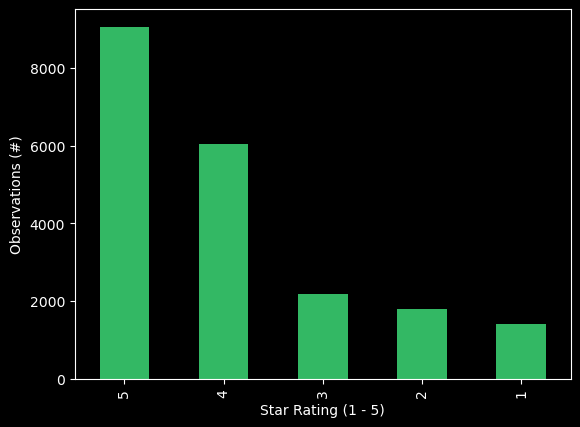

In [3]:
plt.style.use('dark_background')
pd.value_counts(MY_DF['Rating'].values).plot.bar(color = '#33B864')
plt.xlabel('Star Rating (1 - 5)')
plt.ylabel('Observations (#)')
plt.show()

**Data information**

* Here we are confirming the data types of our features.

In [4]:
MY_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


**Checking for** `null` **or missing values**

* No missing data points are present.

In [5]:
MY_DF.isnull().sum()

Review    0
Rating    0
dtype: int64

####**Text Transformer Class**

* Here I have created a custom `TextCleaner` transformer.
  * In order, for a transformer to be integrated into a pipeline as an intermediate step, it needs to contain both a `fit()` and a `transform()` method.  
  * If you want to make your own transformer class, you firstly need to inherit two classes:
    * `BaseEstimator` which provides basic functionality.
    * `TransformerMixin` which combines the `fit()` and the `transform()` methods in your class.
    
    (Shanding, 2023)
* My `TextCleaner` class is initialized with the name of the column that contains the data we wish to preprocess.  
* When the `transform()` method is called in the pipeline, some textual preprocessing techniques (from the inner `CLEAN_UP_TEXT()` function) will be applied to each text sample in the `Review` column of my dataset.
* The `CLEAN_UP_TEXT()` function does the following:
  * Remove any stop words and punctuation.
  * Tokenization, where each separate word in the review text is represented as an individual item.
  * Lemmatization, where each tokenized word is converted to its common base or dictionary form in order for the model to easily determine the meaning of the word within the context of the sentence the word is in or even the entire document.

  (Kargin, 2021)
  
  (Pykes, 2023)

In [6]:
class TextCleaner(BaseEstimator, TransformerMixin):

  def __init__(self, column_name):
    self.column_name = column_name

  def fit(self, X, y = None):
    return self

  def transform(self, data):
    self.data = data

    def CLEAN_UP_TEXT(TXT):
      REMOVED          = stopwords.words('english') + list(punctuation)
      TOKENIZED        = nltk.word_tokenize(TXT)
      TOKEN_WORD       = [W for W in TOKENIZED if W.isalpha()]
      PROCESSED_TOKEN  = [WordNetLemmatizer().lemmatize(W.lower()) for W in TOKEN_WORD if W not in REMOVED]
      CLEANED_TXT      = ' '.join(PROCESSED_TOKEN)
      return CLEANED_TXT

    self.data[self.column_name] = self.data[self.column_name].apply(CLEAN_UP_TEXT)
    return self.data[self.column_name]

####**The "All-In-One" Analysis Function**

* Right, so this function is going to combine literally every step of our text analysis workflow and run everything in one go.
* My `RUN_ANALYSIS()` function has four parameters:
  * `DATA`: the dataset we want to run our analysis on.
  * `RATING`: do you want to perform topic modelling on all the textual data or do you want to filter your textual data by a specific `Rating` score?
  * `NUM_OF_TOPICS`: how many topics or themes do you want to output for your data?
  * `NUM_OF_TOP_WORDS`: how many of the key or feature words do you want to output under each topic? (ranked by weight from highest to lowest)

* The `TfidfVectorizer` class
  * Stands for "Term Frequency - Inverse Document Frequency" (abbreviated as TF-IDF).
  * TF-IDF, in layman terms, is a statistical method used to calculate to how relevant a word is by factoring how many times it appears in a single document and how many times it appears across the entire set of text documents.

  (MonkeyLearn, n.d.)
  
  (GeeksforGeeks, 2023)

* The `LatentDirichletAllocation` class
  * A type of unsupervised clustering algorithm used for grouping key words and documents into topics.
  * LDA uses Gibbs Sampling to estimate the probability of a word being associated with a certain topic.
  * The LDA algorithm assumes that:
    * Documents with the same topics will have a lot of words in common.
    * Each token word is analysed separately without considering its context in a sentence.

    (Maklin, 2022)
* The `Pipeline` shall then sequence all the transformers with the model as the last step and will be ready to receive input data to fit the model once initialized.
* Lastly, the topics extracted from the document will be visually displayed along their key terms and weight values under each of them (plotting code sourced from the `LDA.ipynb` file).

In [7]:
def RUN_ANALYSIS(DATA, RATING = None, NUM_OF_TOPICS = 5, NUM_OF_TOP_WORDS = 10):
  CLEAN = TextCleaner('Review')
  VECT  = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')
  LDA   = LatentDirichletAllocation(n_components = NUM_OF_TOPICS, random_state = 42)
  PIPE  = Pipeline(steps = [('clean', CLEAN), ('vect', VECT), ('lda', LDA)])
  TITLE = ''

  if (RATING is None):
    PIPE.fit(DATA)
    TITLE = 'General'
  else:
    PIPE.fit(DATA[DATA['Rating'] == RATING])
    TITLE = str(RATING)

  fig, axes = plt.subplots(1, NUM_OF_TOPICS, figsize = (15, 7), sharex = True)
  axes      = axes.flatten()
  for topic_idx, topic in enumerate(PIPE.named_steps['lda'].components_):
      top_features_ind = topic.argsort()[: -NUM_OF_TOP_WORDS - 1: -1]
      top_features     = [PIPE.named_steps['vect'].get_feature_names_out()[i] for i in top_features_ind]
      weights          = topic[top_features_ind]

      ax = axes[topic_idx]
      ax.barh(top_features, weights, height = 0.7)
      ax.set_title(f'Topic #{topic_idx + 1} Words:', fontdict = {'fontsize': 10})
      ax.invert_yaxis()
      ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
      for i in 'top right left'.split():
          ax.spines[i].set_visible(False)
      fig.suptitle(TITLE + '-Star Rating Topics', fontsize = 12)
  plt.subplots_adjust(top = 0.90, bottom = 0.05, wspace = 0.90, hspace = 0.3)
  plt.show()

####**Topic Clustering**

* Hypothetically, if we asked ourselves "what concepts are associated with guests that rated their hotel stay 5 stars?" or "what concepts are associated with guests that rated their hotel stay 1 star so we can find out what's the problem with "
* In the case, I am going to call my `RUN_ANALYSIS()` function two times, using a different `RATING` value for both.
* NOTE: the two cells below take a little more than a minute for both to run.

**Filtered by** `RATING = 5`

* Here are some of the topics and key words associated with guests that rated their hotel experience 5/5 stars.
* Notice the words in **Topic #1** such as **great**, **excellent** and **good** are present.
* These words generally carry a **positive** connotation.

C:\Users\lab_services_student\AppData\Local\Temp\ipykernel_4916\539915960.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.column_name] = self.data[self.column_name].apply(CLEAN_UP_TEXT)


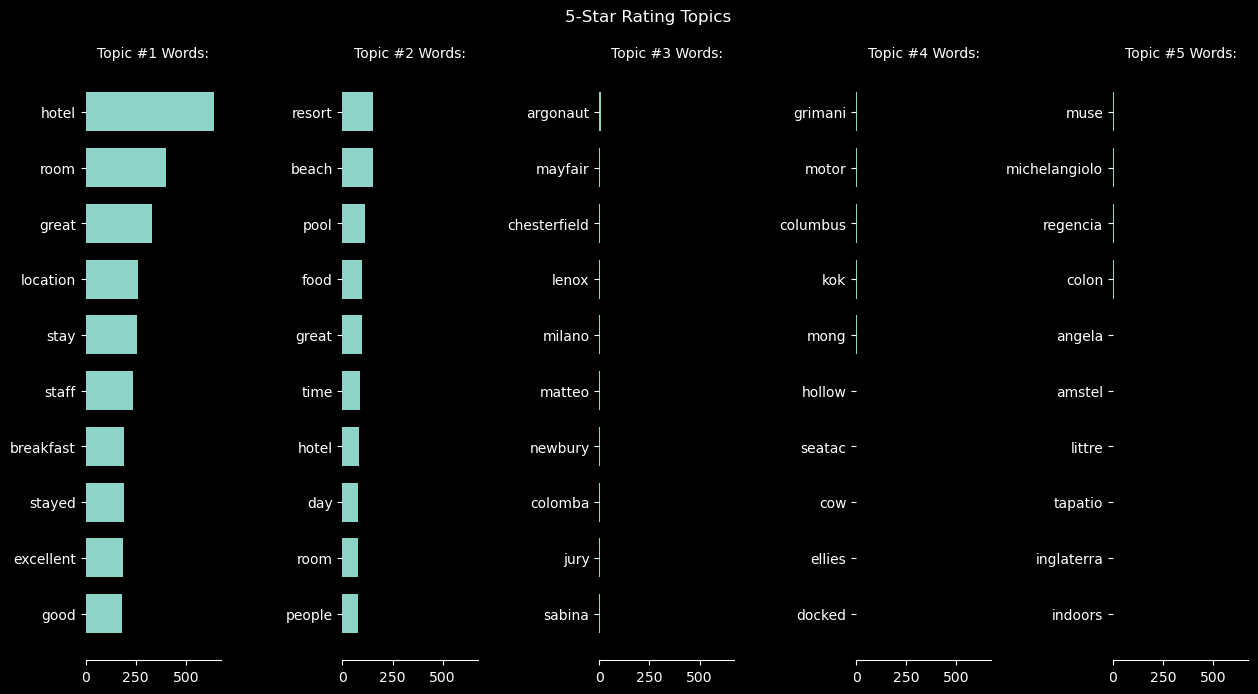

In [8]:
RUN_ANALYSIS(DATA = MY_DF, RATING = 5)

**Filtered by** `RATING = 1`

* Here are some of the topics and key words associated with guests that rated their hotel experience 1/5 stars.
* Notice the words such as **dirty**, **unkept** and **congested** are present.
* These words generally carry a **negative** connotation.

C:\Users\lab_services_student\AppData\Local\Temp\ipykernel_4916\539915960.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.column_name] = self.data[self.column_name].apply(CLEAN_UP_TEXT)


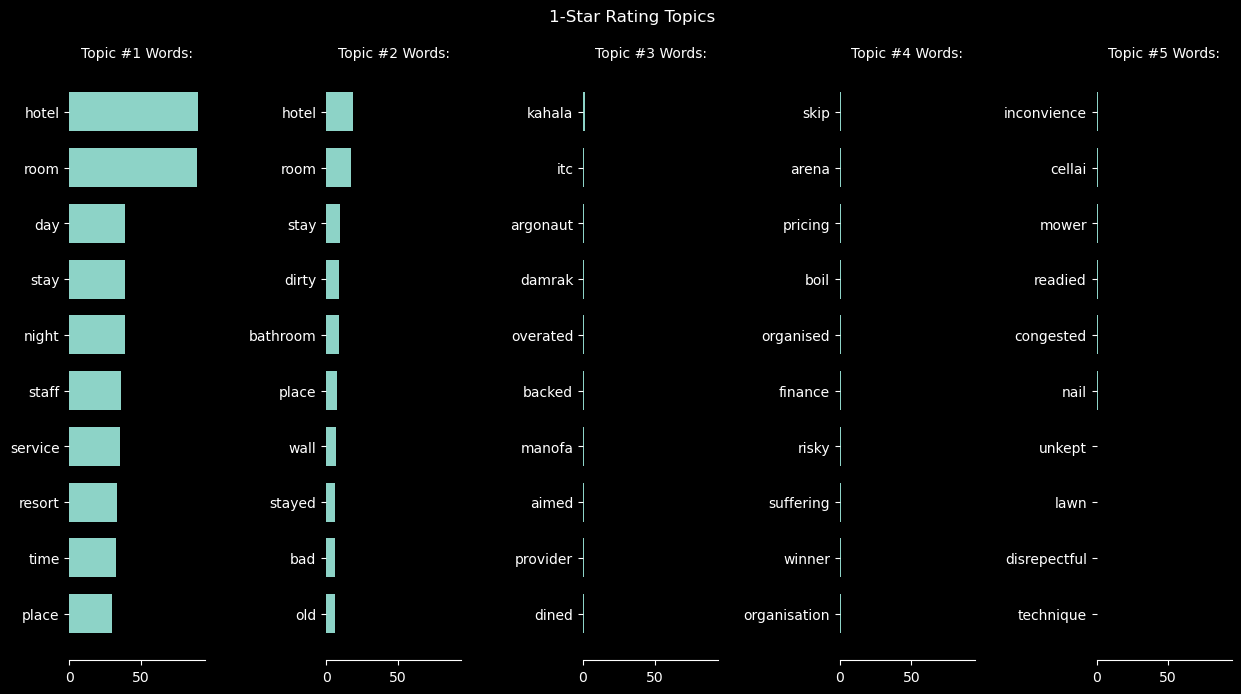

In [9]:
RUN_ANALYSIS(DATA = MY_DF, RATING = 1)

####**References**

* Alam, M. H., Ryu, W.-J., Lee, S., 2016. Joint multi-grain topic senti- ment: modeling semantic aspects for online reviews. Information Sci- ences 339, 206–223.

* GeeksforGeeks, 2023. Understanding TF-IDF (Term Frequency-Inverse Document Frequency). [Online]
Available at: https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/
[Accessed 25 June 2024].

* Gillis, A. S., 2024. natural language processing (NLP). [Online]
Available at: https://www.techtarget.com/searchenterpriseai/definition/natural-language-processing-NLP
[Accessed 25 June 2024].

* Kanade, V., 2022. What is Sentiment Analysis? Definition, Tools, and Applications. [Online]
Available at: https://www.spiceworks.com/tech/artificial-intelligence/articles/what-is-sentiment-analysis/
[Accessed 25 June 2024].

* Kargin, K., 2021. NLP: Tokenization, Stemming, Lemmatization and Part of Speech Tagging. [Online]
Available at: https://keremkargin.medium.com/nlp-tokenization-stemming-lemmatization-and-part-of-speech-tagging-9088ac068768
[Accessed 26 June 2024].

* Maklin, C., 2022. Latent Dirichlet Allocation. [Online]
Available at: https://medium.com/@corymaklin/latent-dirichlet-allocation-dfcea0b1fddc
[Accessed 25 June 2024].

* MonkeyLearn, n.d. Text Processing: What Is It?. [Online]
Available at: https://monkeylearn.com/blog/text-processing/
[Accessed 25 June 2024].

* MonkeyLearn, n.d. Understanding TF-ID: A Simple Introduction. [Online]
Available at: https://monkeylearn.com/blog/what-is-tf-idf/
[Accessed 25 June 2024].

* Pykes, K., 2023. Stemming and Lemmatization in Python. [Online]
Available at: https://www.datacamp.com/tutorial/stemming-lemmatization-python
[Accessed 25 June 2024].

* Pykes, K., 2023. What is Topic Modeling? An Introduction With Examples. [Online]
Available at: https://www.datacamp.com/tutorial/what-is-topic-modeling
[Accessed 26 June 2024].

* Shanding, P. G., 2023. Creating Custom Transformers in Python and scikit-learn. [Online]
Available at: https://medium.com/@pgshanding/creating-custom-transformers-in-python-and-scikit-learn-10767487017e#:~:text
[Accessed 26 June 2024].





